In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Define file paths
data_path = '/Users/srihariramesh/Documents/ScaleDux_Task1/data/Startup_Scoring_Dataset.csv'
output_dir = '../outputs/'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

try:
    df = pd.read_csv(data_path)
    print("Successfully Loaded Dataset")
    print("--- First 5 Rows ---")
    print(df.head())
except FileNotFoundError:
    print("Error: File not found")



Successfully Loaded Dataset
--- First 5 Rows ---
  startup_id  team_experience  market_size_million_usd  monthly_active_users  \
0       S001                7                      789                 66299   
1       S002                4                      939                 34866   
2       S003                8                       42                 73630   
3       S004                5                       57                 93657   
4       S005                7                      512                 61187   

   monthly_burn_rate_inr  funds_raised_inr  valuation_inr  
0                6091495           4183839      263247468  
1                9106842            666326      172927107  
2                8817088            649150      313090455  
3                6374167          20153173      305887183  
4                 841971            118834       84815222  


In [3]:
# Create a copy for normalization
df_normalized = df.copy()

# List of features to normalize
features_to_normalize = [
    'team_experience', 'market_size_million_usd', 'monthly_active_users',
    'monthly_burn_rate_inr', 'funds_raised_inr', 'valuation_inr'
]

# Apply Min-Max normalization
for col in features_to_normalize:
    min_val = df_normalized[col].min()
    max_val = df_normalized[col].max()
    if max_val - min_val > 0:
        df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)
    else:
        df_normalized[col] = 0

# Invert the burn rate score (lower is better -> higher is better)
df_normalized['monthly_burn_rate_inr'] = 1 - df_normalized['monthly_burn_rate_inr']
df_normalized.rename(columns={'monthly_burn_rate_inr': 'burn_efficiency_score'}, inplace=True)

print("--- Normalized Data (First 5 Rows) ---")
print(df_normalized.head())

--- Normalized Data (First 5 Rows) ---
  startup_id  team_experience  market_size_million_usd  monthly_active_users  \
0       S001         0.666667                 0.789206              0.669162   
1       S002         0.333333                 0.941955              0.347274   
2       S003         0.777778                 0.028513              0.744235   
3       S004         0.444444                 0.043788              0.949320   
4       S005         0.666667                 0.507128              0.616813   

   burn_efficiency_score  funds_raised_inr  valuation_inr  
0               0.393230          0.082061       0.518992  
1               0.084439          0.011052       0.333843  
2               0.114112          0.010706       0.621166  
3               0.364283          0.404435       0.606400  
4               0.930815          0.000000       0.153220  


In [4]:
# Define and Apply the Scoring Formula

# Define the weights for each feature. These must sum to 1.0 (or 100%).
weights = {
    'monthly_active_users': 0.25,      # Most important: Real customer traction
    'team_experience': 0.20,           # Second most important: A strong team can execute
    'burn_efficiency_score': 0.15,     # Important: Shows financial discipline
    'market_size_million_usd': 0.15,   # Important: Potential for growth
    'valuation_inr': 0.15,             # Important: A signal of investor confidence
    'funds_raised_inr': 0.10           # Good to have, but less critical than traction
}

# Calculate the health score by multiplying each normalized feature by its weight
df_normalized['health_score'] = (
    df_normalized['monthly_active_users'] * weights['monthly_active_users'] +
    df_normalized['team_experience'] * weights['team_experience'] +
    df_normalized['burn_efficiency_score'] * weights['burn_efficiency_score'] +
    df_normalized['market_size_million_usd'] * weights['market_size_million_usd'] +
    df_normalized['valuation_inr'] * weights['valuation_inr'] +
    df_normalized['funds_raised_inr'] * weights['funds_raised_inr']
)

# Scale the final score to be out of 100 and round it
df_normalized['health_score'] = (df_normalized['health_score'] * 100).round(2)

# Merge the score back into the original dataframe to see it alongside the original data
final_df = df.merge(df_normalized[['startup_id', 'health_score']], on='startup_id')

# Sort the startups by their new score, from highest to lowest
final_df_sorted = final_df.sort_values(by='health_score', ascending=False).reset_index(drop=True)

print("\n--- Final DataFrame with Scores (Top 5) ---")
print(final_df_sorted.head())


--- Final DataFrame with Scores (Top 5) ---
  startup_id  team_experience  market_size_million_usd  monthly_active_users  \
0       S006               10                      416                 95939   
1       S077                9                      357                 86081   
2       S045               10                      743                 80723   
3       S043               10                      105                 89145   
4       S097                9                      686                 66790   

   monthly_burn_rate_inr  funds_raised_inr  valuation_inr  health_score  
0                 551157          48939582      307433345         83.87  
1                1155534          46216125      399998231         79.59  
2                7315795          33737494      417486361         74.89  
3                1468175          40902772      306248071         74.31  
4                1222622          13470137      439431826         74.17  


In [5]:
# Ranking & Specific Interpretation

print("--- Top 10 Startups ---")
print(final_df_sorted.head(10))
print("\n" + "="*80 + "\n")

print("--- Bottom 10 Startups ---")
print(final_df_sorted.tail(10))
print("\n" + "="*80 + "\n")

# Detailed analysis of the #1 ranked startup
top_startup = final_df_sorted.iloc[0]
print(f"\nAnalysis for Top Startup ({top_startup['startup_id']}):")
print(f"This startup achieved the highest score of {top_startup['health_score']} primarily because it excels in the most heavily weighted areas. It demonstrates strong market traction with {top_startup['monthly_active_users']:,} monthly active users and is led by a highly experienced team (score: {top_startup['team_experience']}/10). This powerful combination is why it's ranked #1.")

# Detailed analysis of the last place startup
bottom_startup = final_df_sorted.iloc[-1]
print(f"\nAnalysis for Bottom Startup ({bottom_startup['startup_id']}):")
print(f"This startup's low score of {bottom_startup['health_score']} is due to significant weaknesses in key evaluation criteria. It has very few monthly active users ({bottom_startup['monthly_active_users']:,}) and a low team experience score ({bottom_startup['team_experience']}/10). Even with other factors, the lack of traction and team strength results in the lowest rank in our model.")

--- Top 10 Startups ---
  startup_id  team_experience  market_size_million_usd  monthly_active_users  \
0       S006               10                      416                 95939   
1       S077                9                      357                 86081   
2       S045               10                      743                 80723   
3       S043               10                      105                 89145   
4       S097                9                      686                 66790   
5       S013                8                      735                 83311   
6       S082                9                      394                 96701   
7       S033                5                      867                 63834   
8       S029                7                      804                 87192   
9       S066               10                      655                 83979   

   monthly_burn_rate_inr  funds_raised_inr  valuation_inr  health_score  
0                 551

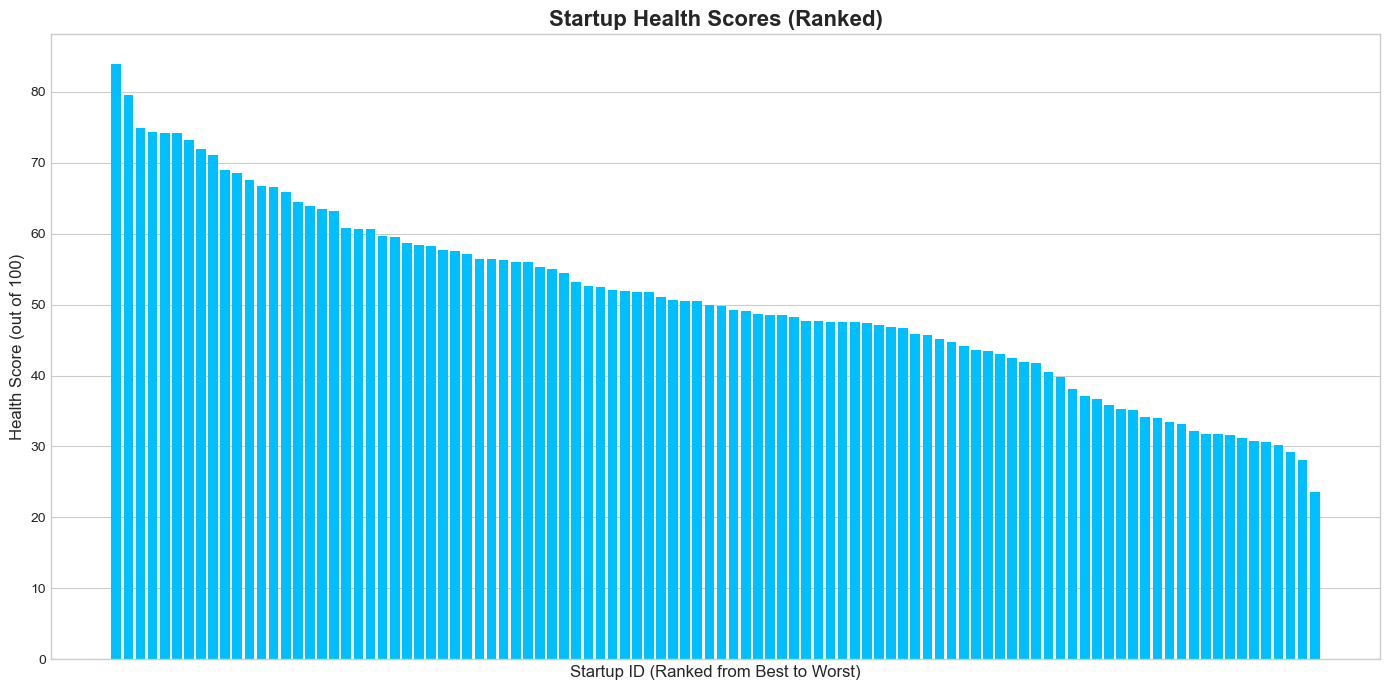

Bar chart saved to: ../outputs/ranked_scores_barchart.png


In [6]:
# Bar Chart of Ranked Scores
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(final_df_sorted['startup_id'], final_df_sorted['health_score'], color='deepskyblue')
ax.set_title('Startup Health Scores (Ranked)', fontsize=16, fontweight='bold')
ax.set_xlabel('Startup ID (Ranked from Best to Worst)', fontsize=12)
ax.set_ylabel('Health Score (out of 100)', fontsize=12)
ax.set_xticks([]) # Hide the startup IDs on the x-axis as there are too many to read
plt.tight_layout()

# Save the figure to the outputs folder
barchart_path = os.path.join(output_dir, 'ranked_scores_barchart.png')
plt.savefig(barchart_path)
plt.show()

print(f"Bar chart saved to: {barchart_path}")

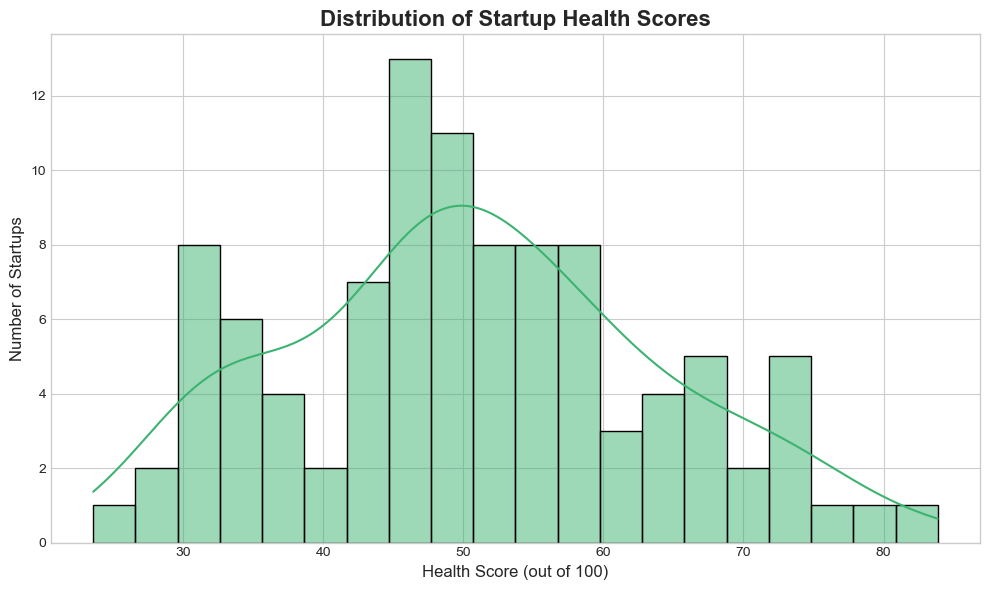

Histogram saved to: ../outputs/score_distribution_histogram.png


In [7]:
# Histogram of Score Distribution
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(final_df_sorted['health_score'], kde=True, bins=20, color='mediumseagreen', ax=ax)
ax.set_title('Distribution of Startup Health Scores', fontsize=16, fontweight='bold')
ax.set_xlabel('Health Score (out of 100)', fontsize=12)
ax.set_ylabel('Number of Startups', fontsize=12)
plt.tight_layout()

# Save the figure
histogram_path = os.path.join(output_dir, 'score_distribution_histogram.png')
plt.savefig(histogram_path)
plt.show()

print(f"Histogram saved to: {histogram_path}")

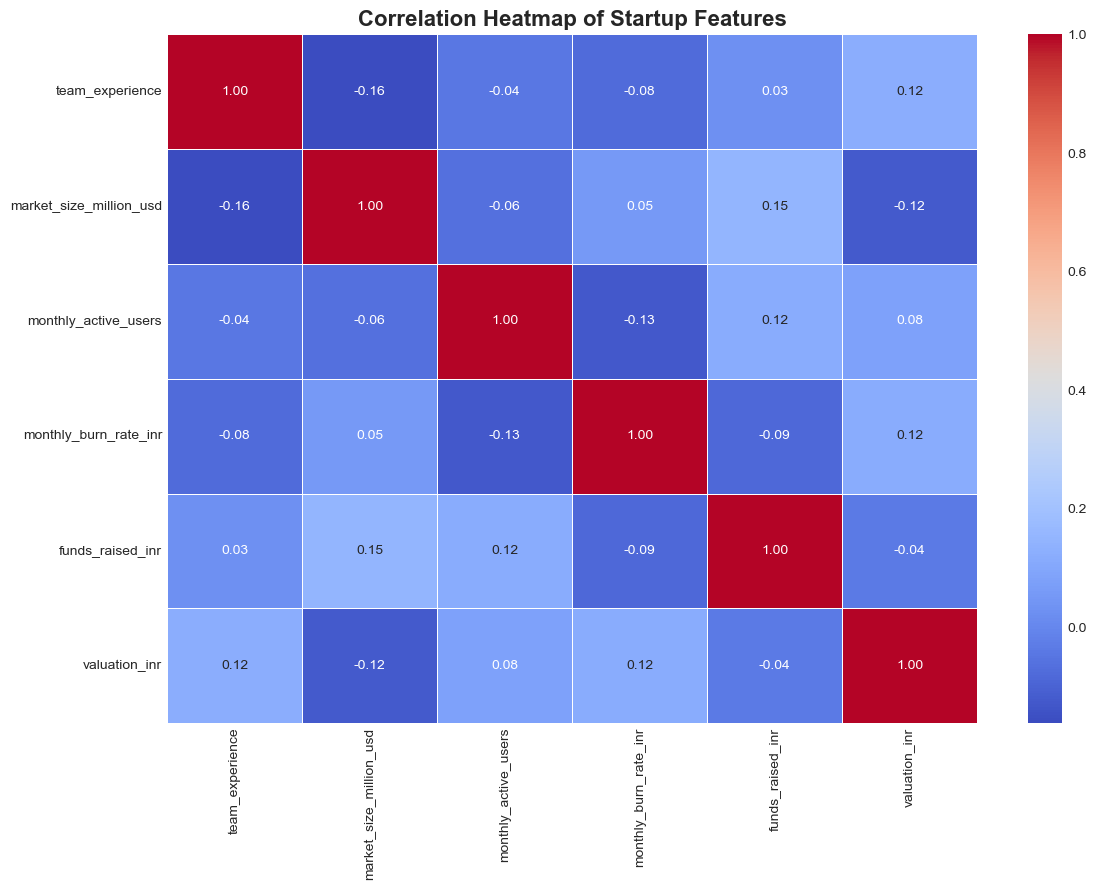

Heatmap saved to: ../outputs/feature_correlation_heatmap.png


In [8]:
# Correlation Heatmap of Original Features
fig, ax = plt.subplots(figsize=(12, 9))

# We use the original dataframe 'df' here to see the natural correlations in the data
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
ax.set_title('Correlation Heatmap of Startup Features', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
heatmap_path = os.path.join(output_dir, 'feature_correlation_heatmap.png')
plt.savefig(heatmap_path)
plt.show()

print(f"Heatmap saved to: {heatmap_path}")